# Hyper-parameter tuning

*This notebook first appeared as a part of [forests-intro](https://github.com/wildtreetech/forests-intro).*

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; display: inline" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Forests intro</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="https://github.com/wildtreetech/forests-intro" property="cc:attributionName" rel="cc:attributionURL">Tim Head</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

*Feel free to use, distribute, and modify with the above attribution.*

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

In [2]:
# Let's use our trusty blob dataset again
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=2000, centers=20, random_state=42)
labels = ["b", "r"]
y = np.take(labels, (y < 10))

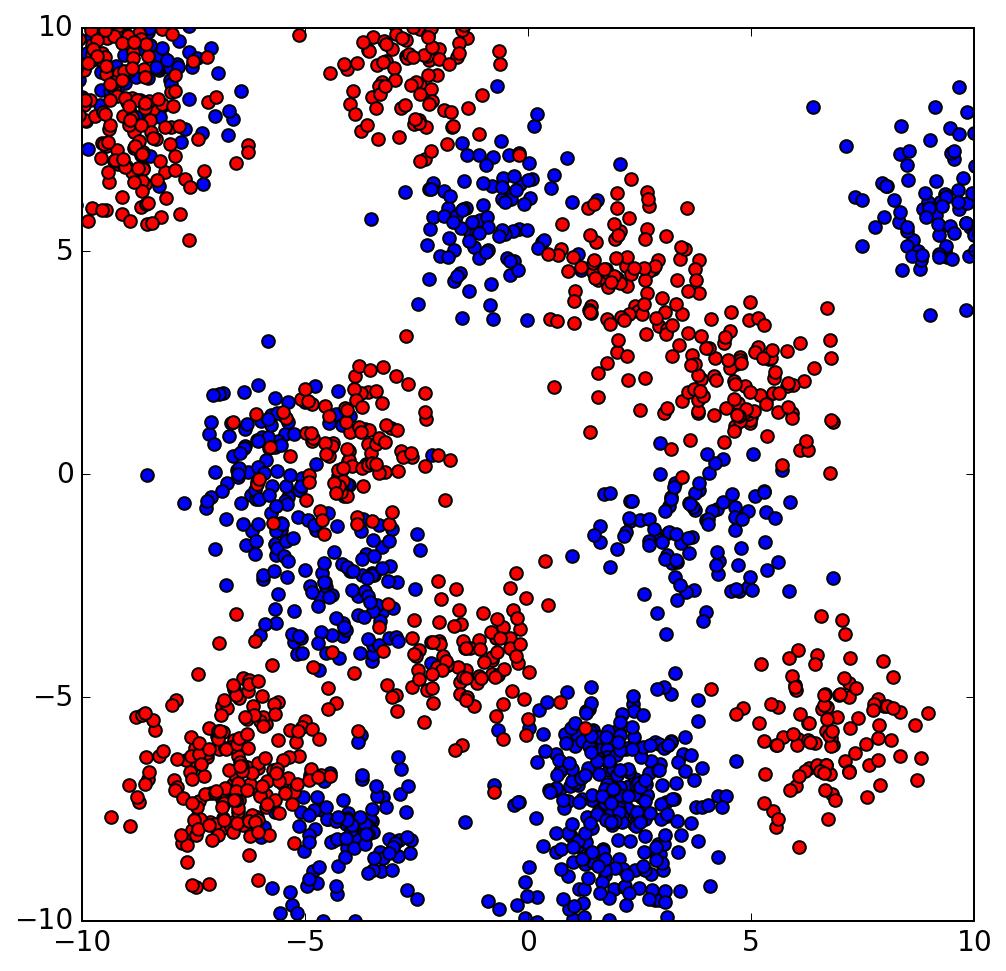

In [3]:
plt.figure()
for label in labels:
    mask = (y == label)
    plt.scatter(X[mask, 0], X[mask, 1], c=label, s=40)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

# What to set all these parameters to??

In [4]:
from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier().get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Aside: Measuring performance

(Quoting from the [scikit-learn documentation](http://scikit-learn.org/dev/modules/cross_validation.html))

Learning the parameters of a prediction function and testing it on the same
data is a methodological mistake: a model that would just repeat the labels
of the samples that it has just seen would have a perfect score but would
fail to predict anything useful on yet-unseen data. This situation is called
overfitting. To avoid it, it is common practice when performing a machine
learning experiment to hold out part of the available data as a test
set `X_test, y_test`.

<img src="img/cross-validation.png" />

In [5]:
from sklearn.cross_validation import cross_val_score
import scipy

clf = RandomForestClassifier()
# should you always use accuracy??
scores = cross_val_score(clf, X, y, scoring='accuracy')
print('scores:', scores)
print('mean:', np.mean(scores), "SEM:", scipy.stats.sem(scores))

scores: [ 0.88323353  0.89489489  0.88588589]
mean: 0.888004771238 SEM: 0.00352912156433


## Back to finding the best hyper-parameters

Now that we know how to measure the performance of a classifier, let's get
back to the real problem of finding the best hyper-parameters for our
`RandomForestClassifier`.

The `GridSearchCV` estimator performs an exhaustive search over the
specified parameter values for an estimator. Using cross-validation
to measure the performance for each combination. Its interface is
exactly the same as that of a normal classifier!

In [6]:
from sklearn.grid_search import GridSearchCV

parameter_grid = {'max_depth': [1, 2, 4, 8, 16, 32, 64],
                  'n_estimators': [10, 20, 40, 80, 120, 160]}
grid_search = GridSearchCV(RandomForestClassifier(), parameter_grid)

grid_search.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 4, 8, 16, 32, 64], 'n_estimators': [10, 20, 40, 80, 120, 160]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [7]:
grid_search.grid_scores_

[mean: 0.59500, std: 0.01000, params: {'max_depth': 1, 'n_estimators': 10},
 mean: 0.61050, std: 0.03114, params: {'max_depth': 1, 'n_estimators': 20},
 mean: 0.62300, std: 0.03628, params: {'max_depth': 1, 'n_estimators': 40},
 mean: 0.60050, std: 0.02747, params: {'max_depth': 1, 'n_estimators': 80},
 mean: 0.61800, std: 0.01678, params: {'max_depth': 1, 'n_estimators': 120},
 mean: 0.61750, std: 0.01164, params: {'max_depth': 1, 'n_estimators': 160},
 mean: 0.69250, std: 0.02475, params: {'max_depth': 2, 'n_estimators': 10},
 mean: 0.68250, std: 0.02957, params: {'max_depth': 2, 'n_estimators': 20},
 mean: 0.70750, std: 0.02353, params: {'max_depth': 2, 'n_estimators': 40},
 mean: 0.70450, std: 0.03099, params: {'max_depth': 2, 'n_estimators': 80},
 mean: 0.71000, std: 0.01962, params: {'max_depth': 2, 'n_estimators': 120},
 mean: 0.71600, std: 0.01902, params: {'max_depth': 2, 'n_estimators': 160},
 mean: 0.81750, std: 0.01475, params: {'max_depth': 4, 'n_estimators': 10},
 mean: 0

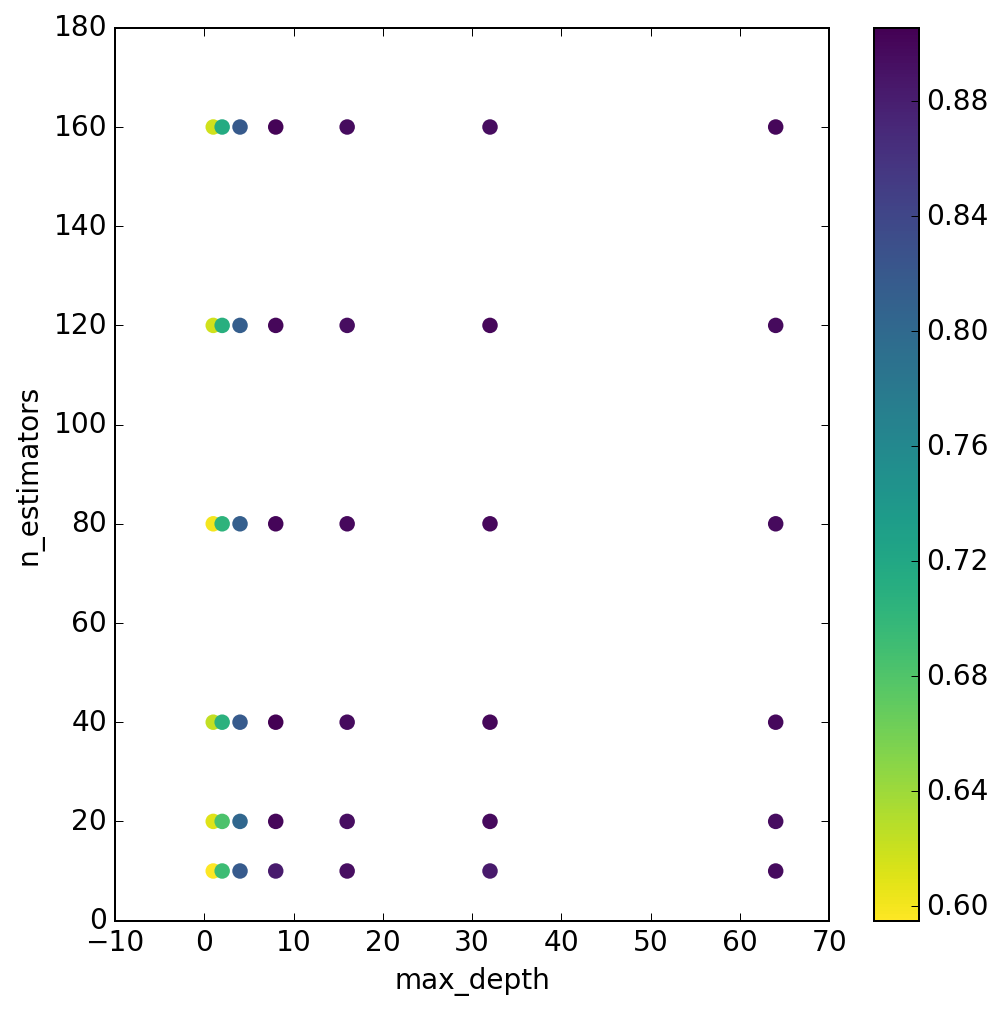

In [8]:
def plot_scores(grid):
    scores = [config.mean_validation_score for config in grid]
    max_depth = [config.parameters['max_depth'] for config in grid]
    n_estimators = [config.parameters['n_estimators'] for config in grid]

    plt.scatter(max_depth, n_estimators, c=scores, s=60, lw=0, cmap='viridis_r')
    plt.xlabel("max_depth")
    plt.ylabel("n_estimators")
    plt.colorbar()
    
plot_scores(grid_search.grid_scores_)

# Randomized grid search

Evaluating every point on a fixed grid can be very expensive and wasteful. In the above
example we learnt that the `n_estimator` dimension is probably not very interesting to
tune.

Randomly sampling the search space allows you to set the budget upfront and "protects"
you from including dimensions that are not interesting.

In [9]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint

parameter_grid = {'max_depth': sp_randint(1, 64),
                  'n_estimators': sp_randint(10, 160)}

random_search = RandomizedSearchCV(RandomForestClassifier(),
                                 parameter_grid,
                                 n_iter=20)

random_search.fit(X, y)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11209f128>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112331668>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

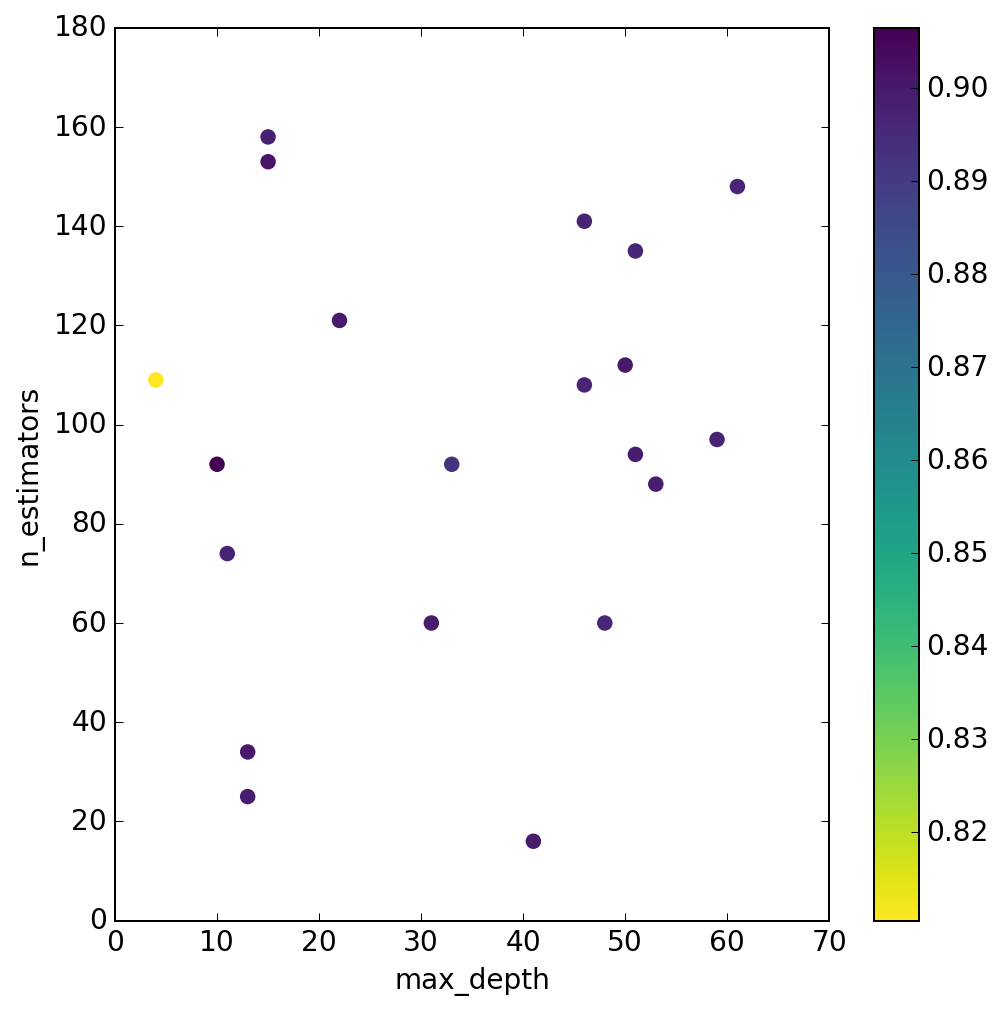

In [10]:
plot_scores(random_search.grid_scores_)

---

## Aside: More sophisticated search methods!?

Sequential model-based optimisation tries to be smarter than random search. This
is very attractive if evaluating your model takes hours or days.

(I work on [`scikit-optimize`](https://scikit-optimize.github.io/) and we have a [hyper-parameter tuning example](https://scikit-optimize.github.io/notebooks/hyperparameter-optimization.html).)

In practice it is hard to beat the simplicity of random search.

---

## Aside: Baselines

Measuring performance without a baseline can be misleading. Use a simple
model or the current method or ... to create a baseline for yourself.

We will use a classifier that always predicts 'red'.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier


classifiers = [('Dummy', DummyClassifier(strategy='constant', constant='r')),
               ('RF', RandomForestClassifier())]
# as this is a toy example you should be able to predict the
# performance of DummyClassifier ahead of time.

In [12]:
for name,classifier in classifiers:
    scores = cross_val_score(classifier, X, y, scoring='accuracy')
    print(name, 'scores:', scores)

Dummy scores: [ 0.5  0.5  0.5]
RF scores: [ 0.88772455  0.90540541  0.88288288]
